# Estimating spherical Gaussian Mixture Models (GMMs) using Tensor Decompositions

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy.linalg as la
from oct2py import octave
octave.addpath('../');

### Generate data

In [46]:
def generate_data():
    A = -dist+(dist+dist)*np.random.rand(d, k)
    X = np.zeros((tot, d))

    plt.axis('equal')

    for i in range(k):
        mean = A[:, i].T
        if spher:
            covariance = s * np.eye(d)
        else:
            a = -cov_range + (cov_range + cov_range) * np.random.rand(d, d)
            covariance = a.T @ a
        mvn = np.random.multivariate_normal(mean, covariance, n)
        #plt.plot(mvn[:, 0], mvn[:, 1], '.')
        #plt.plot(mean[0], mean[1], 'x')
        X[i*n:(i+1)*n, :] = mvn
        
    return (X, A)

### Calculate first order data moment (mean)

In [241]:
def calculate_first_moment(X):
    mu = np.zeros((d, 1))
    for t in range(tot):
        for i in range(d):
            mu[i] += X[t, i]
    mu /= tot
    return mu

### Calculate second order data moment (covariance)

In [39]:
def calculate_second_moment(X):
    Sigma = np.zeros((d, d))
    for t in range(tot):
        for i in range(d):
            for j in range(d):
                Sigma[i, j] += np.dot(X[t, i],X[t, j])
    Sigma /= tot
    return Sigma

### Extract information from second order data moment

In [304]:
def extract_information_from_second_moment(Sigma, X):
    # print("Sigma array\n")
    # print(Sigma)
    # print("\n#####################################################\n")
    U, S, _ = np.linalg.svd(Sigma)
    # print("Unitary array\n")
    # print(U)
    # print("\n#####################################################\n")
    # print("Eigenvalues\n")
    # print(S)
    # print("\n#####################################################\n")
    s_est = S[-1]
    W, X_whit = perform_whitening(X, U, S)
    return (s_est, W, X_whit)

### Perform whitening

In [305]:
def perform_whitening(X, U, S):
    W = U[:, 0:k] @ np.sqrt(np.linalg.pinv(np.diag(S[0:k])))
    # print("Whitening Matrix\n")
    # print(W)
    # print("\n#####################################################\n")
    X_whit = X @ W
    # print("X Whitened\n")
    # print(X_whit)
    # print("\n#####################################################\n")
    return (W, X_whit)

### Perform tensor power method

In [306]:
def perform_tensor_power_method(X_whit, W, s_est, mu):
    TOL = 1e-8
    maxiter = 100
    V_est = np.zeros((k, k))
    lamb = np.zeros((k, 1))
    
    for i in range(k):
        v_old = np.random.rand(k, 1)
        v_old = np.divide(v_old, np.linalg.norm(v_old))
        for iter in range(maxiter):
            v_new = (X_whit.T @ (X_whit @ v_old * X_whit @ v_old))/ tot
            #v_new = v_new - s_est * (W' * mu * dot((W*v_old),(W*v_old)));
            #v_new = v_new - s_est * (2 * W' * W * v_old * ((W'*mu)' * (v_old)));
            v_new -= s_est * ((W.T @ mu) @ np.dot((W @ v_old).T, (W @ v_old)))
            v_new -= s_est * (2 * (W.T @ (W @ (v_old @ ((W.T @ mu).T @ v_old)))))
            if i > 0:
                for j in range(i):
                    v_new -= np.reshape(V_est[:, j] * np.power((v_old.T @ V_est[:, j]), 2) * lamb[j], (k, 1))
            l = np.linalg.norm(v_new)
            v_new = np.divide(v_new, np.linalg.norm(v_new))
            if np.linalg.norm(v_old - v_new) < TOL:
                V_est[:, i] = np.reshape(v_new, k)
                lamb[i] = l
                break
            v_old = v_new
    
    return (V_est, lamb)

### Perform backwards transformation

In [307]:
def perform_backwards_transformation(V_est, lamb):
    # print("V\n")
    # print(V_est)
    # print("\n#####################################################\n")
    # print("Lamb\n")
    # print(lamb)
    # print("\n#####################################################\n")
    # print(np.linalg.pinv(W.T) @ V_est)
    # print("\n#####################################################\n")
    # print(np.diag(np.reshape(lamb.T, k)))
    # print("\n#####################################################\n")
    # print((np.linalg.pinv(W.T) @ V_est) @ np.diag(np.reshape(lamb.T, k)))
    # print("\n#####################################################\n")
    return (np.linalg.pinv(W.T) @ V_est) @ np.diag(np.reshape(lamb.T, k))

### Plot result

In [319]:
def plot_results(X, A, A_est, s_est, FB):
    plt.axis('equal')
    
    ax = plt.subplot(aspect='equal')
    
    plt.plot(X[:,0], X[:,1], '.', zorder=-3)
    
    for i in range(k):
        mean = A[:, i].T
        mean_est = A_est[:, i].T
        
        plt.plot(mean[0], mean[1], 'x', color='y', zorder=-2)
        plt.plot(mean_est[0], mean_est[1], '+', color='r', zorder=-1)
        
        ell = Ellipse(xy=(mean_est[0], mean_est[1]),
                      width=s_est, height=s_est,
                      angle=0, color='red')
        ell.set_facecolor('none')
        ax.add_artist(ell)
    if FB:
        plt.title("FB(GMM)")
    else:
        plt.title("GMM")
    plt.show()

In [320]:
def plot_mixtures(X, FB):
    plt.axis('equal')
    
    ax = plt.subplot(aspect='equal')
    
    plt.plot(X[:,0], X[:,1], '.', zorder=-3)
    if FB:
        plt.title("FB(GMM)")
    else:
        plt.title("GMM")
    plt.show()

# Center Data

In [310]:
def center_gmm(X, A):
    X = X - np.mean(X)
    A = A - np.mean(A)
    return X, A

# Add Noise

In [311]:
def add_noise(X, thresh):
    for i in range(thresh):
        noise = np.random.standard_cauchy((X.shape[1]))
        random_point = np.random.randint(0,X.shape[0])
        X[random_point, :] += noise
    return X

# Execution

[[-7.18005811  3.82751592 -7.45073445  0.76178646  4.58926826 -2.72721799]
 [ 1.27325807  1.92455397 -1.57435825  6.62540433  1.84768385 -7.23476855]
 [ 3.52941103  7.24744509 -4.29982388  1.61369317  3.98408042 -4.52028192]
 [-0.80729257 -5.40241995  6.30178993 -7.78359131 -7.38122351 -6.6188128 ]
 [-7.54706329 -2.58668576 -4.14846082 -7.73610796  7.50883566 -1.00832364]
 [-6.52562695  0.24140139  0.53956515 -0.22622288  3.51635834 -6.54010233]
 [ 8.45832876 -5.15200568 -2.79238099  0.49476811  7.22686845  5.50887674]
 [ 8.08549095  4.73802742 -5.49091071  4.61325655  1.08568621  0.95998738]
 [-6.76960032  0.86240818 -5.02437137  4.43667397  7.74982707 -6.94869403]
 [ 7.07196893 -1.00547169  7.25591839 -4.34932847  6.29482793  6.53563202]]
[[2.41136281 0.         0.         0.         0.         0.        ]
 [0.         2.36330571 0.         0.         0.         0.        ]
 [0.         0.         2.37518412 0.         0.         0.        ]
 [0.         0.         0.         2.38355

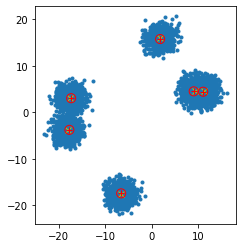

In [207]:
d = 10
k = 6
n = 1000
tot = k * n
s = 2
dist = 20
spher = True
cov_range = 2


X, A = generate_data()
X, A = center_gmm(X, A)
mu = calculate_first_moment(X)
Sigma = calculate_second_moment(X)

s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)

V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)

A_est = perform_backwards_transformation(V_est, lamb)

plot_results(X, A, A_est, s_est)

In [277]:
def support(X, val, q): # Set q to be the qth quantile
    return np.quantile((X.T).dot(val), q)

def compute_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if support(X, X[:,i] / la.norm(X[:,i]), q) > np.dot(X[:,i], X[:,i]/la.norm(X[:,i])): 
            polar_body = np.hstack((polar_body, np.array(X[:,i]).reshape(n,1)))
    return polar_body

In [351]:
def Frobenius_Norm(A, A_):
    return np.sqrt(np.trace(np.subtract(A, A_)@np.subtract(A,A_).conj().T))


def Get_Min(A,A_):
    weights = -abs((A.T@A_)**2)
    ind = octave.munkres(weights)
    fs = [int(x) - 1 for x in list(ind[0])]
    B = A_[:, fs]
    innerprod = np.diag(np.real(A.T@B) < 0)
    B[:,innerprod] = -B[:, innerprod]
    min_ = Frobenius_Norm(B, A)
    return min_

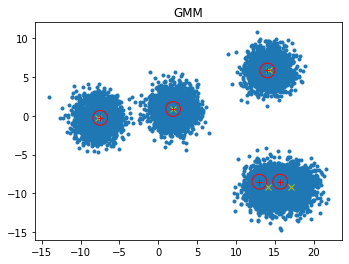

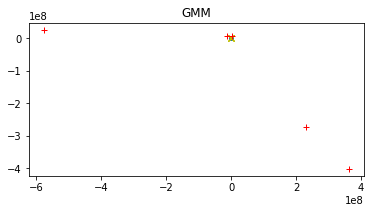

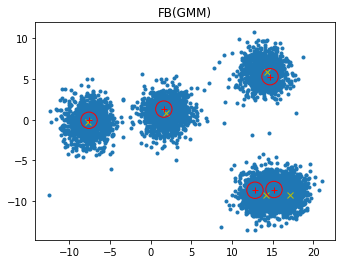

In [630]:
d = 10
k = 5
n = 2000
tot = k * n
s = 2
dist = 20
spher = True
cov_range = 2
###########################################################################
#W/o FB
X, A = generate_data()
X, A = center_gmm(X, A)

#print("\nREGULAR GMM RESULTS\n")
mu = calculate_first_moment(X)
Sigma = calculate_second_moment(X)

s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)

V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)

A_est = perform_backwards_transformation(V_est, lamb)
plot_results(X, A, A_est, s_est, False)
############################################################
#W/FB
X_ = add_noise(X, 1000)
tot = X_.shape[1]

mu_wo = calculate_first_moment(X_)
Sigma_wo = calculate_second_moment(X_)

s_est_wo, W_wo, X_whit_wo = extract_information_from_second_moment(Sigma_wo, X_)

V_est_wo, lamb_wo = perform_tensor_power_method(X_whit_wo, W_wo, s_est_wo, mu_wo)

#print("FB A_est_ print outs")

A_est_wo = perform_backwards_transformation(V_est_wo, lamb_wo)

plot_results(X_, A, A_est_wo, s_est_wo, False)
############################################################
#print("\nFLOATING BODY RESULTS\n")

#W/FB
X_ = compute_fb(X_.T, .95, d)
tot = X_.shape[1]

mu_ = calculate_first_moment(X_.T)
Sigma_ = calculate_second_moment(X_.T)

s_est_, W_, X_whit_ = extract_information_from_second_moment(Sigma_, X_.T)

V_est_, lamb_ = perform_tensor_power_method(X_whit_, W_, s_est_, mu_)

#print("FB A_est_ print outs")

A_est_ = perform_backwards_transformation(V_est_, lamb_)

plot_results(X_.T, A, A_est_, s_est_, True)

In [628]:
normal = np.zeros((2,k))
nofb = np.zeros((2,k))
yesfb = np.zeros((2,k))
OG_fb = np.zeros((2,k))
for i in range(k):
        mean = A_est[:, i].T
        mean_wo = A_est_wo[:, i].T
        mean_est = A_est_[:, i].T
        OG_mean = A[:,i].T
        
        normal[:,i] = np.array([mean[0], mean[1]])
        nofb[:,i] = np.array([mean_wo[0], mean_wo[1]])
        yesfb[:,i] = np.array([mean_est[0], mean_est[1]])
        OG_fb[:,i] = np.array([OG_mean[0], OG_mean[1]])
Get_Min(normal/la.norm(normal,2), yesfb/la.norm(yesfb,2))


0.029692783800352375

In [621]:
print(f"Difference of A and FB: {Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2))}")

Difference of A and FB: 0.5285821707284798


In [622]:
print(f"Difference of No and FB: {Get_Min(normal/la.norm(OG_fb,2), nofb/la.norm(nofb,2))}")

Difference of No and FB: 1.2399909478399742


In [623]:
print(f"Difference of A and Normal: {Get_Min(OG_fb/la.norm(OG_fb,2), nofb/la.norm(nofb,2))}")

Difference of A and Normal: 1.2500622847710199


In [624]:
octave.addpath('/mnt/linuxlab/home/jmontebell2/Github/boobs/');

In [567]:
A_est_wo.shape

(15, 3)